In [2]:
import torch
print(torch.__version__)
torch.cuda.is_available()

2.5.0


True

### Generate sample data

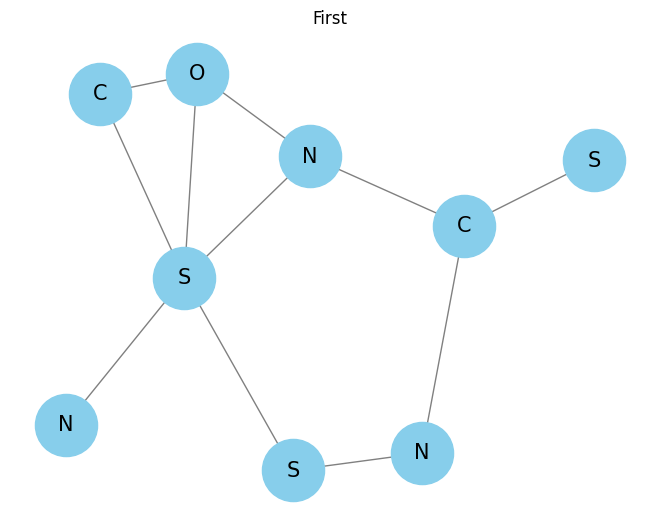

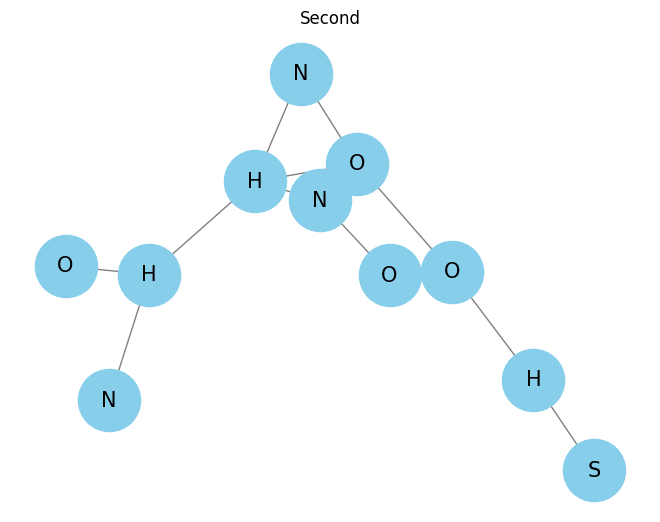

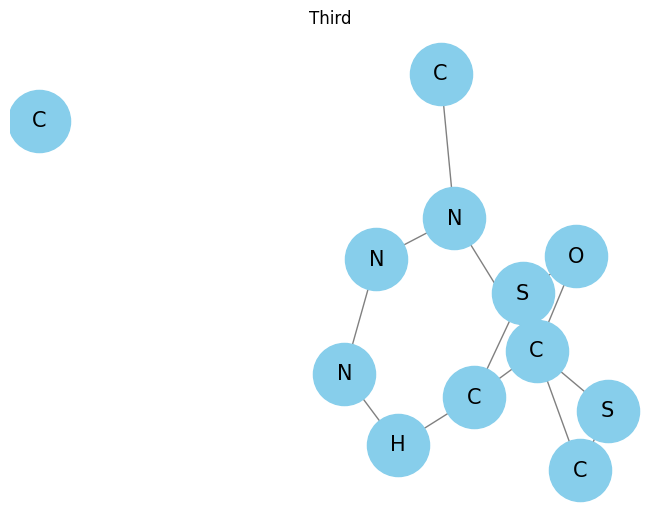

{'potency': 0.5144056576947675}


In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Function to create a random molecular graph
def create_molecular_graph(shift=1):
    G = nx.Graph()
    
    # Define possible atoms and bonds
    atoms = ['C', 'H', 'O', 'N', 'S']
    num_atoms = random.randint(5+shift, 10+shift)  # Random number of atoms
    num_bonds = random.randint(num_atoms - 1 + shift, num_atoms + 2 + shift)  # Random number of bonds
    
    # Add nodes (atoms)
    for i in range(num_atoms):
        G.add_node(i, atom=random.choice(atoms), features=torch.randn(10))
    
    # Add edges (bonds)
    while G.number_of_edges() < num_bonds:
        a, b = random.sample(range(num_atoms), 2)
        G.add_edge(a, b)
    
    return G

# Function to plot a molecular graph
def plot_molecular_graph(G, title):
    pos = nx.spring_layout(G)
    node_labels = {i: G.nodes[i]['atom'] for i in G.nodes()}
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color='skyblue', node_size=2000, font_size=15, font_color='black', edge_color='gray')
    plt.title(title)
    plt.show()

# Generate and plot multiple molecular graphs
graphs = []
for i in range(10000):
    G = create_molecular_graph(shift=1)
    G.graph['potency'] = random.uniform(0,1)
    graphs.append(G)
for i in range(10000):
    G = create_molecular_graph(shift=2)
    G.graph['potency'] = random.uniform(1,2)
    graphs.append(G)
for i in range(10000):
    G = create_molecular_graph(shift=3)
    G.graph['potency'] = random.uniform(2,3)
    graphs.append(G)

plot_molecular_graph(graphs[5000], "First")
plot_molecular_graph(graphs[15000], "Second")
plot_molecular_graph(graphs[25000], "Third")

print(graphs[0].graph)
#     plot_molecular_graph(G, f'Molecular Graph {i + 1}')


### Concatenate dataset

In [34]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Convert NetworkX graphs to PyTorch Geometric Data objects
dataset = []
for G in graphs:
    data = from_networkx(G)
    data.y = torch.tensor(G.graph['potency'], dtype=torch.float)
    dataset.append(data)
    

print(len(dataset))
dataset[-5]


30000


Data(edge_index=[2, 32], atom=[13], features=[13, 10], potency=2.3221793174743652, num_nodes=13, y=2.3221793174743652)

### Validation split

In [35]:
from torch_geometric.loader import DataLoader


# Create DataLoader
from sklearn.model_selection import train_test_split

# Assume 'dataset' is your list of Data objects from previous steps
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)


train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(val_data, batch_size=32, shuffle=True)


### GCN on Graph Potency -- Regression

In [47]:

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

# Hyperparameters
num_classes = 1
num_node_features = 10  # Assuming nodes don't have additional features

# Set the device to CUDA if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class GCN(nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_dim=32):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.features, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        # Apply global mean pooling
        x = global_mean_pool(x, batch) # [batch_size, hidden_dim]

        # Pass through a fully connected layer to get a single prediction
        x = self.fc(x)
        
        return x.view(-1)


# Initialize the model, optimizer and loss function
model = GCN(num_node_features, num_classes, hidden_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

def train(epoch):
    model.train()
    losses = []
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.to(device))
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        
    return torch.tensor(losses).mean()
        
def validate():
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in valid_loader:
            out = model(data.to(device))
            loss = criterion(out, data.y)
            val_loss += loss.item()
    return val_loss / len(valid_loader)

# Train for a few epochs
for epoch in range(100):
    train_loss = train(epoch)
    val_loss = validate()
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}, Training Loss: {train_loss: .4f}, Validation Loss: {val_loss:.4f}')


Epoch 1, Training Loss:  0.7853, Validation Loss: 0.7598
Epoch 6, Training Loss:  0.7421, Validation Loss: 0.7418
Epoch 11, Training Loss:  0.7401, Validation Loss: 0.7390
Epoch 16, Training Loss:  0.7392, Validation Loss: 0.7395
Epoch 21, Training Loss:  0.7388, Validation Loss: 0.7405
Epoch 26, Training Loss:  0.7383, Validation Loss: 0.7371
Epoch 31, Training Loss:  0.7364, Validation Loss: 0.7376
Epoch 36, Training Loss:  0.7364, Validation Loss: 0.7372
Epoch 41, Training Loss:  0.7357, Validation Loss: 0.7420
Epoch 46, Training Loss:  0.7354, Validation Loss: 0.7438


KeyboardInterrupt: 

In [48]:
import torch

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Example tensor on CUDA
x = torch.randn(3, 3).to(device)
print(f'Tensor on {device}: {x}')

# Example: Moving model to CUDA
# Assuming you have a PyTorch model defined as 'model'
# model = YourModel()
# model.to(device)


Using device: cpu
Tensor on cpu: tensor([[-0.0152, -2.8546,  0.9476],
        [ 1.0756, -1.2968, -1.9712],
        [ 1.0207,  0.3987,  0.4409]])


In [49]:
torch.__version__

'1.13.1+cpu'